# Train CNN + LSTM + Attention

## Setup

In [1]:
# Skip this cell if we are not on Google Colab
try:
    # Mount Google Drive to the Colab VM.
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

    # Specify working directory.
    FOLDERNAME = 'cs231n/project/'
    %cd /content/drive/My\ Drive/$FOLDERNAME

    # Ensure that the Python interpreter of the Colab VM can load python files from
    # within it.
    import sys
    sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
except ImportError as e:
    print("Not on Google Colab.")

Not on Google Colab.


## Load dataset and labels

In [2]:
import numpy as np
import os

#base_dir = '/content/drive/My Drive/cs231n/project/dataset/shaped_hrnet_data'
base_dir = '/home/ubuntu'

train_data = np.load(os.path.join(base_dir, 'train_data_pre12.npy'))
train_actions = np.load(os.path.join(base_dir, 'train_actions_pre12.npy'), allow_pickle=True)
train_labels = np.load(os.path.join(base_dir, 'train_labels_pre12.npy'))

val_data = np.load(os.path.join(base_dir, 'val_data_pre12.npy'))
val_actions = np.load(os.path.join(base_dir, 'val_actions_pre12.npy'), allow_pickle=True)
val_labels = np.load(os.path.join(base_dir, 'val_labels_pre12.npy'))

In [3]:
print('Training data shape: ', train_data.shape)
print('Training label shape: ', train_labels.shape)
print('Training action shape: ', train_actions.shape)
print('Train Label=1 ratio:', np.sum(train_labels) /train_labels.shape[0])
print('Validation data shape: ', val_data.shape)
print('Validation label shape: ', val_labels.shape)
print('Validation action shape: ', val_actions.shape)
print('Validation Label=1 ratio:', np.sum(val_labels) / val_labels.shape[0])

Training data shape:  (1007, 12, 224, 224, 3)
Training label shape:  (1007,)
Training action shape:  (1007,)
Train Label=1 ratio: 0.24925521350546176
Validation data shape:  (433, 12, 224, 224, 3)
Validation label shape:  (433,)
Validation action shape:  (433,)
Validation Label=1 ratio: 0.2517321016166282


In [12]:
mapping = {
    'CALL': 0,
    'COUG': 1,
    'DRIN': 2,
    'SCRA': 3,
    'SNEE': 4,
    'STRE': 5,
    'WAVE': 6,
    'WIPE': 7,
}
train_action_labels = [mapping[x] for x in train_actions]
val_action_labels = [mapping[x] for x in val_actions]

# One-hot encoding.
train_action_labels = np.eye(8)[train_action_labels] 
val_action_labels = np.eye(8)[val_action_labels] 

## 1. CNN + LSTM Model

### 1.1 Define model

In [5]:
from keras.layers import Multiply, Activation, RepeatVector, Bidirectional, Lambda, Permute, multiply, Input, TimeDistributed, Conv2D, Dense, MaxPooling2D, Flatten, LSTM, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras import models, Model
from keras import backend as K
from keras_self_attention import SeqSelfAttention
from keras.regularizers import l2

frames, channels, rows, columns = 12, 3, 224, 224

video = Input(shape=(frames,rows,columns,channels))

initialiser = 'glorot_uniform'
reg_lambda = 1e-3

model = models.Sequential()
model.add(Input(shape=(frames, rows, columns, channels)))



model.add(TimeDistributed(Conv2D(32, (3, 3), 
                                 strides=(2, 2), 
                                 padding='same',
                                 kernel_initializer=initialiser, 
                                 kernel_regularizer=l2(reg_lambda))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(Conv2D(32, (3,3), 
                                 kernel_initializer=initialiser, 
                                 kernel_regularizer=l2(reg_lambda))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
          

model.add(TimeDistributed(Conv2D(64, (3,3), 
                                 padding='same',
                                 kernel_initializer=initialiser, 
                                 kernel_regularizer=l2(reg_lambda))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation('relu')))         
model.add(TimeDistributed(Conv2D(64, (3,3), 
                                 padding='same',
                                 kernel_initializer=initialiser, 
                                 kernel_regularizer=l2(reg_lambda))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation('relu')))      
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))


# model.add(TimeDistributed(Conv2D(128, (3,3), 
#                                  padding='same',
#                                  kernel_initializer=initialiser, 
#                                  kernel_regularizer=l2(reg_lambda))))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(Activation('relu')))         
# model.add(TimeDistributed(Conv2D(128, (3,3), 
#                                  padding='same',
#                                  kernel_initializer=initialiser, 
#                                  kernel_regularizer=l2(reg_lambda))))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(Activation('relu')))      
# model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
          
# model.add(TimeDistributed(Conv2D(256, (3,3), 
#                                  padding='same',
#                                  kernel_initializer=initialiser, 
#                                  kernel_regularizer=l2(reg_lambda))))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(Activation('relu')))         
# model.add(TimeDistributed(Conv2D(256, (3,3), 
#                                  padding='same',
#                                  kernel_initializer=initialiser, 
#                                  kernel_regularizer=l2(reg_lambda))))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(Activation('relu')))      
# model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

          

# model.add(TimeDistributed(Conv2D(512, (3,3), 
#                                  padding='same',
#                                  kernel_initializer=initialiser, 
#                                  kernel_regularizer=l2(reg_lambda))))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(Activation('relu')))         
# model.add(TimeDistributed(Conv2D(512, (3,3), 
#                                  padding='same',
#                                  kernel_initializer=initialiser, 
#                                  kernel_regularizer=l2(reg_lambda))))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(Activation('relu')))      
# model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

          

#model.add(TimeDistributed(Conv2D(16, (3, 3), padding = 'same', activation='relu')))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(Conv2D(64, (3, 3), padding = 'same', activation='relu', kernel_regularizer=l2(1e-2))))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D(2,2)))

#model.add(TimeDistributed(Conv2D(64, (3, 3), padding = 'same', activation='relu', kernel_regularizer=l2(1e-2))))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D(2,2)))


#model.add(TimeDistributed(Conv2D(128, (3, 3), padding = 'same', activation='relu')))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D(2,2)))

#model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.2))

#model.add(Masking(mask_value=special_value))
model.add(LSTM(32, dropout=0.25, recurrent_dropout=0.1, return_sequences=False)) # used 64 units
#model.add(SeqSelfAttention(attention_activation='sigmoid'))
#model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax')) # n_labels = 8
model.summary()

# #cnn_base.add(Conv2D(128, (3, 3), activation='relu'))
# #cnn_base.add(Conv2D(128, (3, 3), activation='relu'))
# #cnn_base.add(MaxPooling2D((2, 2)))

# #cnn_base.add(Conv2D(256, (3, 3), activation='relu'))
# #cnn_base.add(Conv2D(256, (3, 3), activation='relu'))
# #cnn_base.add(MaxPooling2D((2, 2)))

# #cnn_base.add(Conv2D(512, (3, 3), activation='relu'))
# #cnn_base.add(Conv2D(512, (3, 3), activation='relu'))
# #cnn_base.add(Conv2D(512, (3, 3), activation='relu'))
# #cnn_base.add(MaxPooling2D((2, 2)))

# #cnn_out = GlobalAveragePooling2D()(cnn_base.output)
# cnn_base.add(Flatten())
# cnn = Model(cnn_base.input, cnn_base.output)
# encoded_frames = TimeDistributed(cnn)(video)
# #encoded_sequence = LSTM(16, return_sequences=True)(encoded_frames)

# #Attention Block:
# units = 16
# #activations =Bidirectional(LSTM(units, return_sequences=True, dropout = 0.2, recurrent_dropout = 0.2))(encoded_frames)
# activations = LSTM(units, return_sequences=True, dropout = 0.25, recurrent_dropout = 0.1)(encoded_frames)
# attention_mul = SeqSelfAttention(attention_activation = 'sigmoid')(activations)
# #attention_mul = Flatten()(attention_mul)
# attention_mul = Dropout(0.2)(attention_mul)
# #attention=Dense(1, activation='tanh')(activations)
# #attention=Flatten()(attention)
# #attention=Activation('softmax')(attention)
# #attention=RepeatVector(units)(attention)
# #attention=RepeatVector(units*2)(attention) #Bidirectional lstm need to have units*2
# #attention=Permute((2, 1))(attention)
# #sent_representation = Multiply()([activations, attention])
# #sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)
# #attention_mul = Dense(1, activation = 'sigmoid')(sent_representation)



# #attention_mul = attention_block(encoded_sequence, frames)
# #attention_mul = Flatten()(attention_mul)

# #x = Dense(128, activation="relu")(attention_mul)
# x = Dense(32, activation="relu")(attention_mul)
# #x = BatchNormalization()(x)
# #x = Dense(64, activation="relu")(x)
# #x = Dense(32, activation="relu")(x)
# x = Dropout(0.2)(x)
# #outputs = Dense(8, activation="softmax")(x)
# outputs = Dense(8, activation="softmax")(x)

# model = Model(video, outputs)
#model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 12, 112, 112, 32)  896       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 12, 112, 112, 32)  128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 12, 112, 112, 32)  0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 12, 110, 110, 32)  9248      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 12, 110, 110, 32)  128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 12, 110, 110, 32)  0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 12, 55, 55, 32)    0

In [7]:
import keras
import tensorflow as tf
callbacks_list = [keras.callbacks.EarlyStopping(monitor='accuracy', patience=50),
                  keras.callbacks.ModelCheckpoint(
                      filepath='cnn_lstm_clean_model_v6',
                      monitor='val_loss',
                      save_best_only=True
                  ),
                  keras.callbacks.ReduceLROnPlateau(
                      monitor="val_loss", factor=0.1, patience=50
                  )]

from keras import optimizers

step = tf.Variable(0, trainable=False)
boundaries = [30, 60, 90, 120, 150, 180]
values = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)
learning_rate = learning_rate_fn(step)

optimizer_new=optimizers.Adam(lr=1e-4)
#optimizer_new=optimizers.SGD(lr=1e-4, momentum=0.9)
#optimizer_new=optimizers.SGD(lr=learning_rate)
model.compile(optimizer=optimizer_new,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

### 1.2 Train model

In [8]:
history = model.fit(train_data, train_action_labels,
                    validation_data=(val_data, val_action_labels),
                    batch_size=20, epochs=60,
                    callbacks=callbacks_list
                    )

Epoch 1/60
51/51 [==============================] - 62s 1s/step - loss: 2.2664 - accuracy: 0.1285 - val_loss: 2.2326 - val_accuracy: 0.1085
INFO:tensorflow:Assets written to: cnn_lstm_clean_model_v6/assets
Epoch 2/60
51/51 [==============================] - 43s 845ms/step - loss: 2.2383 - accuracy: 0.1184 - val_loss: 2.2279 - val_accuracy: 0.1247
INFO:tensorflow:Assets written to: cnn_lstm_clean_model_v6/assets
Epoch 3/60
51/51 [==============================] - 40s 794ms/step - loss: 2.2288 - accuracy: 0.1404 - val_loss: 2.2301 - val_accuracy: 0.1224
Epoch 4/60
51/51 [==============================] - 40s 795ms/step - loss: 2.2258 - accuracy: 0.1366 - val_loss: 2.2251 - val_accuracy: 0.1224
INFO:tensorflow:Assets written to: cnn_lstm_clean_model_v6/assets
Epoch 5/60
51/51 [==============================] - 40s 793ms/step - loss: 2.2160 - accuracy: 0.1341 - val_loss: 2.2311 - val_accuracy: 0.1224
Epoch 6/60
51/51 [==============================] - 40s 794ms/step - loss: 2.2156 - accura

51/51 [==============================] - 40s 793ms/step - loss: 1.8376 - accuracy: 0.3783 - val_loss: 2.1080 - val_accuracy: 0.2102
Epoch 51/60
51/51 [==============================] - 40s 792ms/step - loss: 1.8522 - accuracy: 0.3803 - val_loss: 2.0993 - val_accuracy: 0.2032
Epoch 52/60
51/51 [==============================] - 40s 795ms/step - loss: 1.7986 - accuracy: 0.4072 - val_loss: 2.1037 - val_accuracy: 0.2102
Epoch 53/60
51/51 [==============================] - 41s 797ms/step - loss: 1.7977 - accuracy: 0.3694 - val_loss: 2.1003 - val_accuracy: 0.2217
Epoch 54/60
51/51 [==============================] - 41s 797ms/step - loss: 1.7926 - accuracy: 0.3771 - val_loss: 2.0972 - val_accuracy: 0.2079
INFO:tensorflow:Assets written to: cnn_lstm_clean_model_v6/assets
Epoch 55/60
51/51 [==============================] - 41s 795ms/step - loss: 1.7362 - accuracy: 0.4301 - val_loss: 2.0953 - val_accuracy: 0.2148
INFO:tensorflow:Assets written to: cnn_lstm_clean_model_v6/assets
Epoch 56/60
51/5

### 1.3 Visualize Train/Valid accuracy & loss, confusion matrix

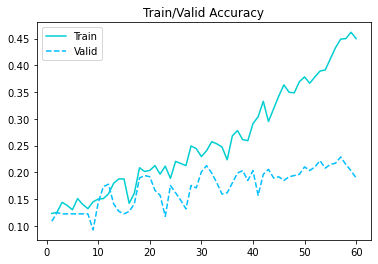

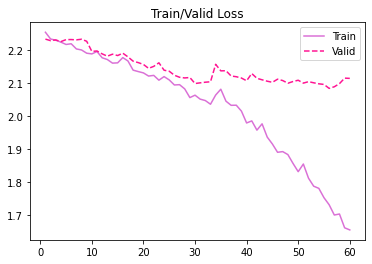

In [9]:
###Plot train/valid accuracy & loss
import matplotlib.pyplot as plt

acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epoch_stop = len(acc)
epochs=np.arange(1, epoch_stop+1)

plt.plot(epochs, acc, label = "Train", color = 'darkturquoise')
plt.plot(epochs, val_acc, label = "Valid", linestyle="--", color = 'deepskyblue')
plt.legend()
plt.title('Train/Valid Accuracy')
plt.show()

plt.plot(epochs, loss, label = "Train", color = 'orchid')
plt.plot(epochs, val_loss, label = "Valid", linestyle="--", color = 'deeppink')
plt.legend()
plt.title('Train/Valid Loss')
plt.show()

In [11]:
import keras
# Predictions on validation data:
val_preds = model.predict(val_data)
val_preds = np.argmax(val_preds,axis=1)
val_true = [mapping[x] for x in val_actions]

<AxesSubplot:>

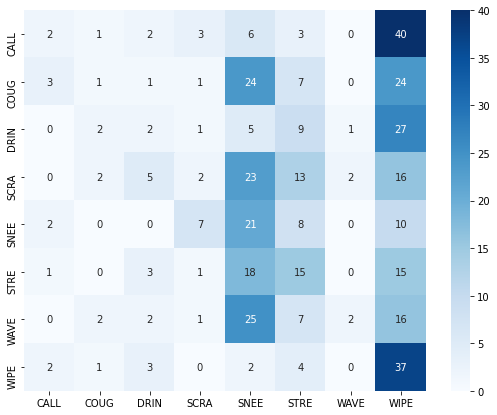

In [12]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_true=val_true, y_pred=val_preds)
df_cm = pd.DataFrame(confusion_matrix, index = mapping.keys(),
                  columns = mapping.keys())
plt.figure(figsize = (9,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [13]:
# COUG:1, SNEE:4
val_true_bin = [x in (1, 4) for x in val_true]
val_preds_bin = [x in (1, 4) for x in val_preds]

<AxesSubplot:>

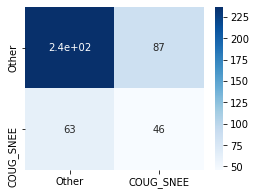

In [14]:
confusion_matrix = metrics.confusion_matrix(y_true=val_true_bin, y_pred=val_preds_bin)
df_cm = pd.DataFrame(confusion_matrix, index = ['Other', 'COUG_SNEE'],
                  columns = ['Other', 'COUG_SNEE'])
plt.figure(figsize = (4,3))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [15]:
tn, fp, fn, tp = confusion_matrix.ravel()

prec = tp/(tp+fp)
rec = tp/(tp+fn)
acc = tp / (tp+fp+fn)

print('Prec.%', prec)
print('Rec.%', rec)
print('Acc.%', acc)

Prec.% 0.3458646616541353
Rec.% 0.42201834862385323
Acc.% 0.23469387755102042


### 1.4 Save model and loss history

In [23]:
###Save history
np.save(os.path.join(base_dir, "cnn_lstm_clean_v6_history"), history.history)
###Save model
model.save(os.path.join(base_dir, "cnn_lstm_clean_v6.h5"))   

#Load history:
#history = np.load(os.path.join(base_dir, "cnn_lstm_clean_v1_history.npy"), allow_pickle=True)

#Load saved model:
#model = keras.models.load_model(os.path.join(base_dir, "cnn_lstm_clean_v1.h5"))

### 1.5 Evaluation on test data

In [16]:
#Load Test Data:
base_dir = '/home/ubuntu'
test_data = np.load(os.path.join(base_dir, 'test_data_pre12.npy'))
test_actions = np.load(os.path.join(base_dir, 'test_actions_pre12.npy'), allow_pickle=True)

In [17]:
# Predictions on test data:
test_preds = model.predict(test_data)
test_preds = np.argmax(test_preds,axis=1)
test_true = [mapping[x] for x in test_actions]

<AxesSubplot:>

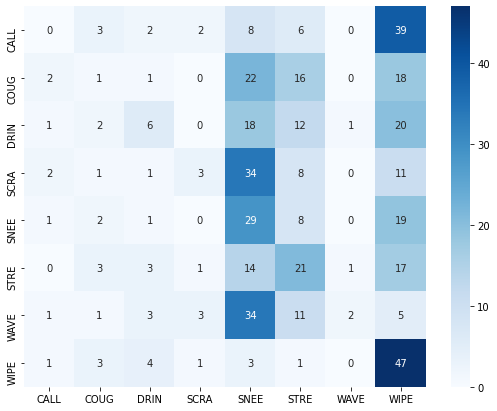

In [18]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_true=test_true, y_pred=test_preds)
df_cm = pd.DataFrame(confusion_matrix, index = mapping.keys(),
                  columns = mapping.keys())
plt.figure(figsize = (9,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [19]:
# COUG:1, SNEE:4
test_true_bin = [x in (1, 4) for x in test_true]
test_preds_bin = [x in (1, 4) for x in test_preds]

<AxesSubplot:>

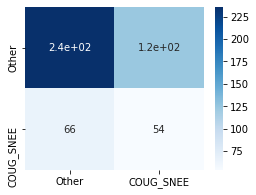

In [21]:
confusion_matrix = metrics.confusion_matrix(y_true=test_true_bin, y_pred=test_preds_bin)
df_cm = pd.DataFrame(confusion_matrix, index = ['Other', 'COUG_SNEE'],
                  columns = ['Other', 'COUG_SNEE'])
plt.figure(figsize = (4,3))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [22]:
tn, fp, fn, tp = confusion_matrix.ravel()

prec = tp/(tp+fp)
rec = tp/(tp+fn)
acc = tp / (tp+fp+fn)

print('Prec.%', prec)
print('Rec.%', rec)
print('Acc.%', acc)

Prec.% 0.30337078651685395
Rec.% 0.45
Acc.% 0.22131147540983606


## 2. CNN + LSTM + Attention Model

### 2.1 Define model

In [5]:
from keras.layers import Multiply, Activation, RepeatVector, Bidirectional, Lambda, Permute, multiply, Input, TimeDistributed, Conv2D, Dense, MaxPooling2D, Flatten, LSTM, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras import models, Model
from keras import backend as K
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
from keras.regularizers import l2

frames, channels, rows, columns = 12, 3, 224, 224

video = Input(shape=(frames,rows,columns,channels))

initialiser = 'glorot_uniform'
reg_lambda = 1e-3

model = models.Sequential()
model.add(Input(shape=(frames, rows, columns, channels)))



model.add(TimeDistributed(Conv2D(32, (3, 3), 
                                 strides=(2, 2), 
                                 padding='same',
                                 kernel_initializer=initialiser, 
                                 kernel_regularizer=l2(reg_lambda))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(Conv2D(32, (3,3), 
                                 kernel_initializer=initialiser, 
                                 kernel_regularizer=l2(reg_lambda))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
          

model.add(TimeDistributed(Conv2D(64, (3,3), 
                                 padding='same',
                                 kernel_initializer=initialiser, 
                                 kernel_regularizer=l2(reg_lambda))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation('relu')))         
model.add(TimeDistributed(Conv2D(64, (3,3), 
                                 padding='same',
                                 kernel_initializer=initialiser, 
                                 kernel_regularizer=l2(reg_lambda))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Activation('relu')))      
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))


# model.add(TimeDistributed(Conv2D(128, (3,3), 
#                                  padding='same',
#                                  kernel_initializer=initialiser, 
#                                  kernel_regularizer=l2(reg_lambda))))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(Activation('relu')))         
# model.add(TimeDistributed(Conv2D(128, (3,3), 
#                                  padding='same',
#                                  kernel_initializer=initialiser, 
#                                  kernel_regularizer=l2(reg_lambda))))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(Activation('relu')))      
# model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
          
# model.add(TimeDistributed(Conv2D(256, (3,3), 
#                                  padding='same',
#                                  kernel_initializer=initialiser, 
#                                  kernel_regularizer=l2(reg_lambda))))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(Activation('relu')))         
# model.add(TimeDistributed(Conv2D(256, (3,3), 
#                                  padding='same',
#                                  kernel_initializer=initialiser, 
#                                  kernel_regularizer=l2(reg_lambda))))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(Activation('relu')))      
# model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

          

# model.add(TimeDistributed(Conv2D(512, (3,3), 
#                                  padding='same',
#                                  kernel_initializer=initialiser, 
#                                  kernel_regularizer=l2(reg_lambda))))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(Activation('relu')))         
# model.add(TimeDistributed(Conv2D(512, (3,3), 
#                                  padding='same',
#                                  kernel_initializer=initialiser, 
#                                  kernel_regularizer=l2(reg_lambda))))
# model.add(TimeDistributed(BatchNormalization()))
# model.add(TimeDistributed(Activation('relu')))      
# model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

          

#model.add(TimeDistributed(Conv2D(16, (3, 3), padding = 'same', activation='relu')))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(Conv2D(64, (3, 3), padding = 'same', activation='relu', kernel_regularizer=l2(1e-2))))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D(2,2)))

#model.add(TimeDistributed(Conv2D(64, (3, 3), padding = 'same', activation='relu', kernel_regularizer=l2(1e-2))))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D(2,2)))


#model.add(TimeDistributed(Conv2D(128, (3, 3), padding = 'same', activation='relu')))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D(2,2)))

#model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu')))
#model.add(TimeDistributed(BatchNormalization()))
#model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.2))

#model.add(Masking(mask_value=special_value))
model.add(LSTM(32, dropout=0.25, recurrent_dropout=0.1, return_sequences=True)) # used 64 units
#model.add(SeqSelfAttention(attention_activation='sigmoid'))
model.add(SeqWeightedAttention())
#model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='softmax')) # n_labels = 8
model.summary()

# #cnn_base.add(Conv2D(128, (3, 3), activation='relu'))
# #cnn_base.add(Conv2D(128, (3, 3), activation='relu'))
# #cnn_base.add(MaxPooling2D((2, 2)))

# #cnn_base.add(Conv2D(256, (3, 3), activation='relu'))
# #cnn_base.add(Conv2D(256, (3, 3), activation='relu'))
# #cnn_base.add(MaxPooling2D((2, 2)))

# #cnn_base.add(Conv2D(512, (3, 3), activation='relu'))
# #cnn_base.add(Conv2D(512, (3, 3), activation='relu'))
# #cnn_base.add(Conv2D(512, (3, 3), activation='relu'))
# #cnn_base.add(MaxPooling2D((2, 2)))

# #cnn_out = GlobalAveragePooling2D()(cnn_base.output)
# cnn_base.add(Flatten())
# cnn = Model(cnn_base.input, cnn_base.output)
# encoded_frames = TimeDistributed(cnn)(video)
# #encoded_sequence = LSTM(16, return_sequences=True)(encoded_frames)

# #Attention Block:
# units = 16
# #activations =Bidirectional(LSTM(units, return_sequences=True, dropout = 0.2, recurrent_dropout = 0.2))(encoded_frames)
# activations = LSTM(units, return_sequences=True, dropout = 0.25, recurrent_dropout = 0.1)(encoded_frames)
# attention_mul = SeqSelfAttention(attention_activation = 'sigmoid')(activations)
# #attention_mul = Flatten()(attention_mul)
# attention_mul = Dropout(0.2)(attention_mul)
# #attention=Dense(1, activation='tanh')(activations)
# #attention=Flatten()(attention)
# #attention=Activation('softmax')(attention)
# #attention=RepeatVector(units)(attention)
# #attention=RepeatVector(units*2)(attention) #Bidirectional lstm need to have units*2
# #attention=Permute((2, 1))(attention)
# #sent_representation = Multiply()([activations, attention])
# #sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(units*2,))(sent_representation)
# #attention_mul = Dense(1, activation = 'sigmoid')(sent_representation)



# #attention_mul = attention_block(encoded_sequence, frames)
# #attention_mul = Flatten()(attention_mul)

# #x = Dense(128, activation="relu")(attention_mul)
# x = Dense(32, activation="relu")(attention_mul)
# #x = BatchNormalization()(x)
# #x = Dense(64, activation="relu")(x)
# #x = Dense(32, activation="relu")(x)
# x = Dropout(0.2)(x)
# #outputs = Dense(8, activation="softmax")(x)
# outputs = Dense(8, activation="softmax")(x)

# model = Model(video, outputs)
#model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 12, 112, 112, 32)  896       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 12, 112, 112, 32)  128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 12, 112, 112, 32)  0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 12, 110, 110, 32)  9248      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 12, 110, 110, 32)  128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 12, 110, 110, 32)  0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 12, 55, 55, 32)    0

In [6]:
import keras
import tensorflow as tf
callbacks_list = [keras.callbacks.EarlyStopping(monitor='accuracy', patience=50),
                  keras.callbacks.ModelCheckpoint(
                      filepath='cnn_lstm_attn_clean_model_v6',
                      monitor='val_loss',
                      save_best_only=True
                  ),
                  keras.callbacks.ReduceLROnPlateau(
                      monitor="val_loss", factor=0.1, patience=50
                  )]

from keras import optimizers

step = tf.Variable(0, trainable=False)
boundaries = [30, 60, 90, 120, 150, 180]
values = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6]
learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)
learning_rate = learning_rate_fn(step)

optimizer_new=optimizers.Adam(lr=1e-4)
#optimizer_new=optimizers.SGD(lr=1e-4, momentum=0.9)
#optimizer_new=optimizers.SGD(lr=learning_rate)
model.compile(optimizer=optimizer_new,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

### 2.2 Train model

In [7]:
history = model.fit(train_data, train_action_labels,
                    validation_data=(val_data, val_action_labels),
                    batch_size=20, epochs=60,
                    callbacks=callbacks_list
                    )

Epoch 1/60
51/51 [==============================] - 63s 1s/step - loss: 2.2442 - accuracy: 0.1191 - val_loss: 2.2211 - val_accuracy: 0.1409
INFO:tensorflow:Assets written to: cnn_lstm_attn_clean_model_v6/assets
Epoch 2/60
51/51 [==============================] - 43s 848ms/step - loss: 2.2244 - accuracy: 0.0967 - val_loss: 2.2211 - val_accuracy: 0.1455
Epoch 3/60
51/51 [==============================] - 41s 799ms/step - loss: 2.2067 - accuracy: 0.1475 - val_loss: 2.2110 - val_accuracy: 0.1409
INFO:tensorflow:Assets written to: cnn_lstm_attn_clean_model_v6/assets
Epoch 4/60
51/51 [==============================] - 41s 796ms/step - loss: 2.2068 - accuracy: 0.1229 - val_loss: 2.1949 - val_accuracy: 0.1386
INFO:tensorflow:Assets written to: cnn_lstm_attn_clean_model_v6/assets
Epoch 5/60
51/51 [==============================] - 41s 796ms/step - loss: 2.1830 - accuracy: 0.1579 - val_loss: 2.1956 - val_accuracy: 0.1478
Epoch 6/60
51/51 [==============================] - 40s 795ms/step - loss: 

51/51 [==============================] - 40s 792ms/step - loss: 1.8447 - accuracy: 0.3067 - val_loss: 2.0302 - val_accuracy: 0.2055
Epoch 46/60
51/51 [==============================] - 40s 791ms/step - loss: 1.8534 - accuracy: 0.2539 - val_loss: 2.0279 - val_accuracy: 0.2079
Epoch 47/60
51/51 [==============================] - 40s 792ms/step - loss: 1.8286 - accuracy: 0.3006 - val_loss: 1.9431 - val_accuracy: 0.2425
Epoch 48/60
51/51 [==============================] - 40s 794ms/step - loss: 1.8285 - accuracy: 0.3048 - val_loss: 2.1128 - val_accuracy: 0.1871
Epoch 49/60
51/51 [==============================] - 40s 795ms/step - loss: 1.8330 - accuracy: 0.2858 - val_loss: 1.8938 - val_accuracy: 0.2818
INFO:tensorflow:Assets written to: cnn_lstm_attn_clean_model_v6/assets
Epoch 50/60
51/51 [==============================] - 40s 792ms/step - loss: 1.8247 - accuracy: 0.2948 - val_loss: 1.8980 - val_accuracy: 0.2425
Epoch 51/60
51/51 [==============================] - 40s 793ms/step - loss: 1

### 2.3 Visualize Train/Valid accuracy & loss, confusion matrix

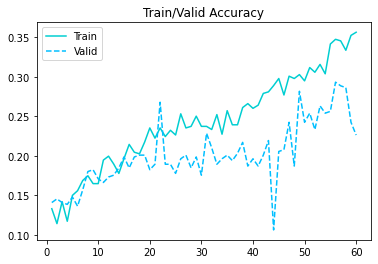

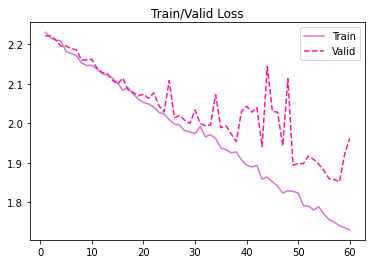

In [10]:
###Plot train/valid accuracy & loss
import matplotlib.pyplot as plt

acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epoch_stop = len(acc)
epochs=np.arange(1, epoch_stop+1)

plt.plot(epochs, acc, label = "Train", color = 'darkturquoise')
plt.plot(epochs, val_acc, label = "Valid", linestyle="--", color = 'deepskyblue')
plt.legend()
plt.title('Train/Valid Accuracy')
plt.show()

plt.plot(epochs, loss, label = "Train", color = 'orchid')
plt.plot(epochs, val_loss, label = "Valid", linestyle="--", color = 'deeppink')
plt.legend()
plt.title('Train/Valid Loss')
plt.show()

In [14]:
import keras
# Predictions on validation data:
val_preds = model.predict(val_data)
val_preds = np.argmax(val_preds,axis=1)
val_true = [mapping[x] for x in val_actions]

<AxesSubplot:>

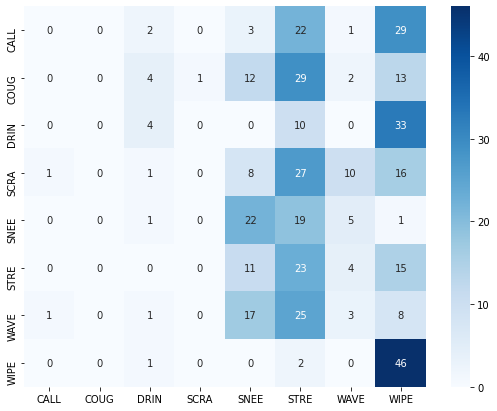

In [15]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_true=val_true, y_pred=val_preds)
df_cm = pd.DataFrame(confusion_matrix, index = mapping.keys(),
                  columns = mapping.keys())
plt.figure(figsize = (9,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [16]:
# COUG:1, SNEE:4
val_true_bin = [x in (1, 4) for x in val_true]
val_preds_bin = [x in (1, 4) for x in val_preds]

<AxesSubplot:>

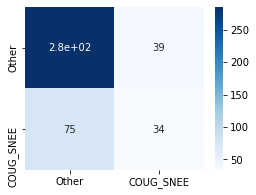

In [17]:
confusion_matrix = metrics.confusion_matrix(y_true=val_true_bin, y_pred=val_preds_bin)
df_cm = pd.DataFrame(confusion_matrix, index = ['Other', 'COUG_SNEE'],
                  columns = ['Other', 'COUG_SNEE'])
plt.figure(figsize = (4,3))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [18]:
tn, fp, fn, tp = confusion_matrix.ravel()

prec = tp/(tp+fp)
rec = tp/(tp+fn)
acc = tp / (tp+fp+fn)

print('Prec.%', prec)
print('Rec.%', rec)
print('Acc.%', acc)

Prec.% 0.4657534246575342
Rec.% 0.3119266055045872
Acc.% 0.22972972972972974


### 2.4 Save model and loss history

In [19]:
###Save history
np.save(os.path.join(base_dir, "cnn_lstm_attn_clean_v6_history"), history.history)
###Save model
model.save(os.path.join(base_dir, "cnn_lstm_attn_clean_v6.h5"))   

#Load history:
#history = np.load(os.path.join(base_dir, "cnn_lstm_attn_clean_v1_history.npy"), allow_pickle=True)

#Load saved model:
#model = keras.models.load_model(os.path.join(base_dir, "cnn_lstm_attn_clean_v1.h5"))

### 2.5 Evaluation on test data

In [20]:
#Load Test Data:
base_dir = '/home/ubuntu'
test_data = np.load(os.path.join(base_dir, 'test_data_pre12.npy'))
test_actions = np.load(os.path.join(base_dir, 'test_actions_pre12.npy'), allow_pickle=True)

In [21]:
# Predictions on test data:
test_preds = model.predict(test_data)
test_preds = np.argmax(test_preds,axis=1)
test_true = [mapping[x] for x in test_actions]

<AxesSubplot:>

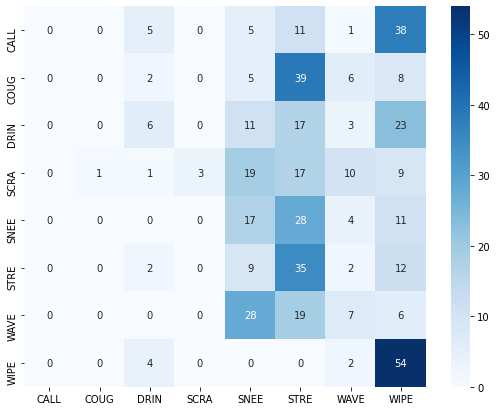

In [22]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

confusion_matrix = metrics.confusion_matrix(y_true=test_true, y_pred=test_preds)
df_cm = pd.DataFrame(confusion_matrix, index = mapping.keys(),
                  columns = mapping.keys())
plt.figure(figsize = (9,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [23]:
# COUG:1, SNEE:4
test_true_bin = [x in (1, 4) for x in test_true]
test_preds_bin = [x in (1, 4) for x in test_preds]

<AxesSubplot:>

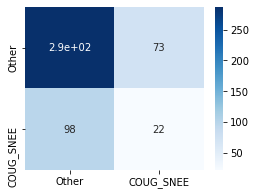

In [24]:
confusion_matrix = metrics.confusion_matrix(y_true=test_true_bin, y_pred=test_preds_bin)
df_cm = pd.DataFrame(confusion_matrix, index = ['Other', 'COUG_SNEE'],
                  columns = ['Other', 'COUG_SNEE'])
plt.figure(figsize = (4,3))
sn.heatmap(df_cm, annot=True, cmap="Blues")

In [25]:
tn, fp, fn, tp = confusion_matrix.ravel()

prec = tp/(tp+fp)
rec = tp/(tp+fn)
acc = tp / (tp+fp+fn)

print('Prec.%', prec)
print('Rec.%', rec)
print('Acc.%', acc)

Prec.% 0.23157894736842105
Rec.% 0.18333333333333332
Acc.% 0.11398963730569948


### 2.6 Compare Train/Valid Accuracy, Loss for both modles

In [26]:
#load model history
history_with_attn = np.load(os.path.join(base_dir, "cnn_lstm_attn_clean_v6_history.npy"), allow_pickle=True)
history_no_attn = np.load(os.path.join(base_dir, "cnn_lstm_clean_v6_history.npy"), allow_pickle=True)

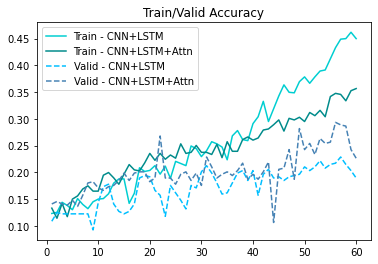

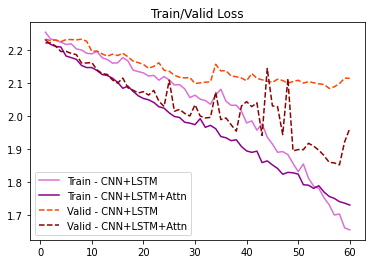

In [27]:
###Plot train/valid accuracy & loss
import matplotlib.pyplot as plt

#no attention
acc=history_no_attn.item()["accuracy"]
val_acc=history_no_attn.item()["val_accuracy"]
loss=history_no_attn.item()["loss"]
val_loss=history_no_attn.item()["val_loss"]

#with attention
acc_attn=history_with_attn.item()["accuracy"]
val_acc_attn=history_with_attn.item()["val_accuracy"]
loss_attn=history_with_attn.item()["loss"]
val_loss_attn=history_with_attn.item()["val_loss"]

epoch_stop = len(acc)
epochs=np.arange(1, epoch_stop+1)

plt.plot(epochs, acc, label = "Train - CNN+LSTM", color = 'darkturquoise')
plt.plot(epochs, acc_attn, label = "Train - CNN+LSTM+Attn", color = 'darkcyan')
plt.plot(epochs, val_acc, label = "Valid - CNN+LSTM", linestyle="--", color = 'deepskyblue')
plt.plot(epochs, val_acc_attn, label = "Valid - CNN+LSTM+Attn", linestyle="--", color = 'steelblue')
plt.legend()
plt.title('Train/Valid Accuracy')
plt.show()

plt.plot(epochs, loss, label = "Train - CNN+LSTM", color = 'orchid')
plt.plot(epochs, loss_attn, label = "Train - CNN+LSTM+Attn", color = 'darkmagenta')
plt.plot(epochs, val_loss, label = "Valid - CNN+LSTM", linestyle="--", color = 'orangered')
plt.plot(epochs, val_loss_attn, label = "Valid - CNN+LSTM+Attn", linestyle="--", color = 'darkred')
plt.legend()
plt.title('Train/Valid Loss')
plt.show()

## Summary

* Some observations:
    - More complex CNN structure tends to overfit the training data (can get very close to 100%), but validation accuracy is only 20%
    - Adding L2 regularization helps reduce overfitting, but not much
    
* **CNN + LSTM**:
    - Model file: cnn_lstm_clean_v6.h5
    - Loss history: cnn_lstm_clean_v6_history.npy
    
* **CNN + LSTM + Attention**:
    - Model file: cnn_lstm_attn_clean_v6.h5
    - Loss history: cnn_lstm_attn_clean_v6_history.npy